**Analytical Solution**

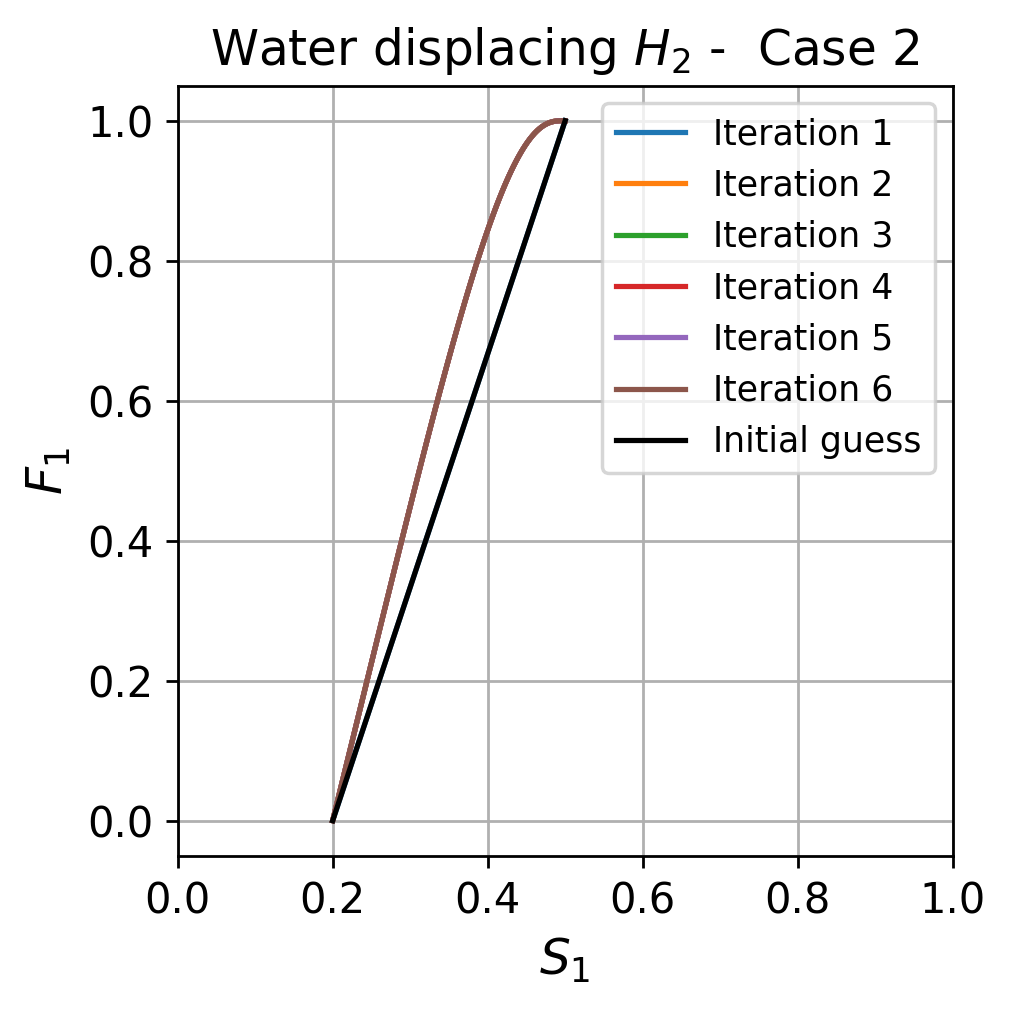

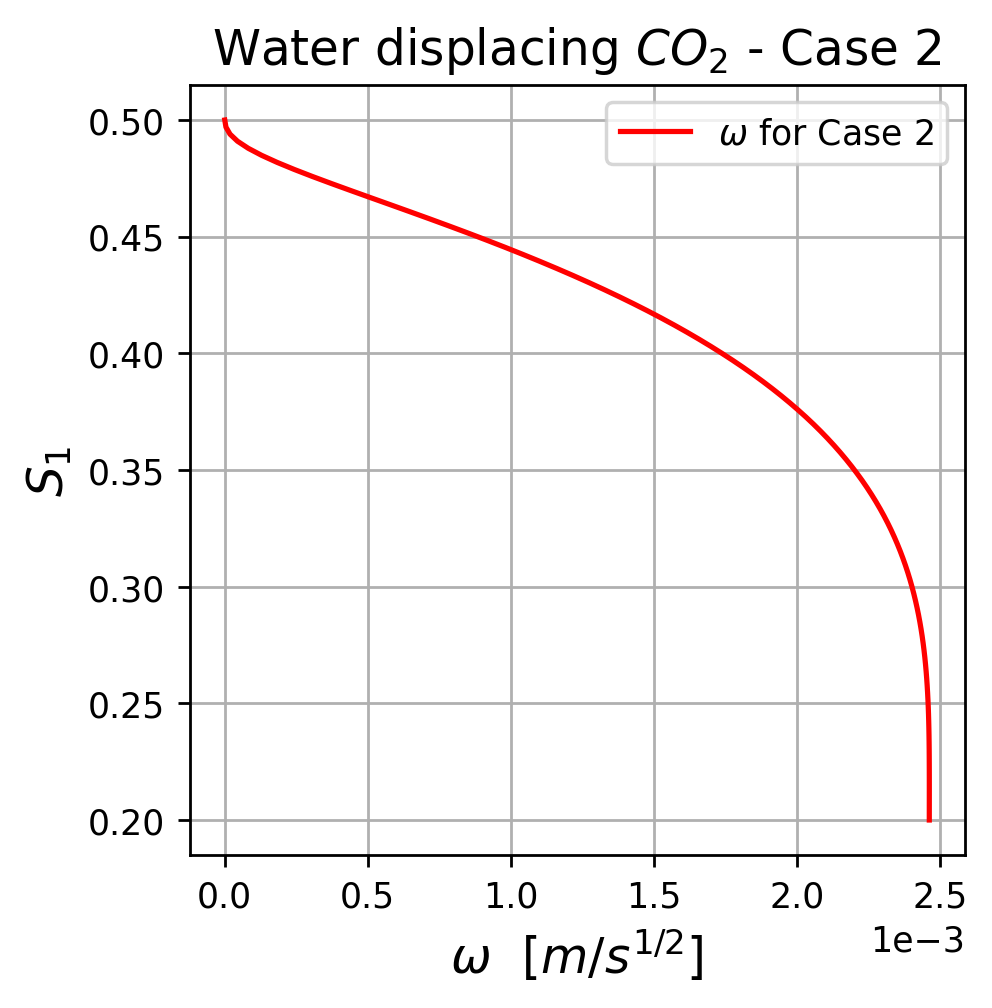

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.interpolate import interp1d

# =============================================================================
# 1. PARAMETERS
# =============================================================================
phi     = 0.25     # porosity
k       = 1e-13    # permeability [m^2]
mu1     = 0.001    # wetting-phase viscosity (water)
mu2     = 0.0001   # non-wetting-phase viscosity (H2)

S1i     = 0.2      # irreducible (connate) wetting saturation (S_{1i})
S2r     = 0.5      # residual non-wetting saturation
S1_star = 0.5      # upper saturation where Pc = 0 (S_1^*)

kr1_max = 0.15     # max wetting-phase relative permeability
kr2_max = 1.0      # max non-wetting-phase relative permeability
a       = 4.0      # exponent for kr1
b       = 1.5      # exponent for kr2

p_c_max = 100e3    # p_c^max [Pa] (100 kPa)
c_exp   = 0.3      # exponent 'c' in the Pc formula

# Saturation range
S = np.linspace(S1i, S1_star, 100)

# =============================================================================
# 2. CAPILLARY PRESSURE AND RELATIVE PERMEABILITY
# =============================================================================
# Capillary pressure (Pc)
Pc = p_c_max * (((S1_star / S1i) ** (-c_exp) - (S / S1i) ** (-c_exp)) / ((S1_star / S1i) ** (-c_exp) - 1))

# Relative permeabilities (kr1 and kr2)
kr1 = kr1_max * ((S - S1i) / (S1_star - S1i)) ** a
kr2 = kr2_max * ((1 - S - S2r) / (1 - S1i - S2r)) ** b

# =============================================================================
# 3. DIFFUSION COEFFICIENT (D)
# =============================================================================
# Calculate the diffusion coefficient
constant = (kr1 * kr2 / (mu1 * mu2)) / ((kr1 / mu1) + (kr2 / mu2)) * k * (-1)
D = constant[:-1] * np.diff(Pc) / np.diff(S)

# Update saturation range for D
S_D = S[:-1]

# =============================================================================
# 4. ITERATIVE CALCULATION OF F1 AND C²
# =============================================================================
# Interpolate D(S) for integration
D_interp = interp1d(S_D, D, kind='cubic', fill_value="extrapolate")

# Initial guess for F1
def F1_initial(S1):
    if S1 <= S1i:
        return 0
    elif S1 >= S1_star:
        return 1
    else:
        return (S1 - S1i) / (S1_star - S1i)

# Integrand for C² calculation
def integrand_C2(beta, F1_func):
    return (beta - S1i) * D_interp(beta) / F1_func(beta)

# Integrand for F1 calculation
def integrand_F1(beta, S1, F1_func):
    return (beta - S1) * D_interp(beta) / F1_func(beta)

# Calculate C²
def calculate_C2(F1_func):
    return phi / 2 * quad(integrand_C2, S1i, S1_star, args=(F1_func))[0]

# Update F1 using C²
def update_F1(S1, C2, F1_func):
    if S1 <= S1i:
        return 0
    elif S1 >= S1_star:
        return 1
    else:
        integral_result, _ = quad(integrand_F1, S1, S1_star, args=(S1, F1_func))
        return 1 - phi / (2 * C2) * integral_result

# Iteration settings
tolerance = 1e-6
max_iterations = 10
converged = False

# Initialize F1_func
F1_func = F1_initial

# Iterate to find F1 and C²
for iteration in range(max_iterations):
    # Update F1 values
    F1_values = [update_F1(S1, calculate_C2(F1_func), F1_func) for S1 in S]

    # Interpolate new F1 values
    F1_func_new = interp1d(S, F1_values, kind='cubic', fill_value="extrapolate")

    # Check for convergence
    F1_changes = np.abs(np.array(F1_values) - np.array([F1_func(S1) for S1 in S]))
    if np.all(F1_changes < tolerance):
        converged = True
        break

    # Update F1_func for next iteration
    F1_func = F1_func_new

if not converged:
    raise ValueError("Iteration did not converge within the maximum number of iterations.")

# Final results
C2 = calculate_C2(F1_func)
C_case2 = np.sqrt(C2)
F1_case2 = F1_func(S)

# Calculate omega
omega_3 = (2 * C_case2 / phi) * np.gradient(F1_case2, S)

# =============================================================================
# 5. PLOTS
# =============================================================================
# Plot F1 vs Saturation
plt.figure(figsize=(4, 4), dpi=250)
# Initialize Fw_iterations with the initial guess
Fw_iterations = [[F1_initial(S1) for S1 in S]]

for i in range(iteration + 1): # iteration is the final iteration number from the loop
    plt.plot(S, Fw_iterations[i], label=f'Iteration {i+1}') # Plot values from each iteration

    # Update Fw_iterations for next potential plotting
    Fw_iterations.append([F1_func(S1) for S1 in S]) if i < iteration else None

plt.plot(S, (S - S1i)/(S1_star - S1i), 'k', label='Initial guess')
plt.xlabel(r'$S_{1}$', fontsize=14)
plt.xlim(0, 1)
plt.ylabel(r'$F_{1}$', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('Water displacing $H_{2}$ -  Case 2', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

# Plot omega vs Saturation
plt.figure(figsize=(4, 4), dpi=250)
plt.plot(omega_3, S, label=r'$\omega$ for Case 2', color='red')
plt.xlabel(r'$\omega$  $[m/s^{1/2}]$', fontsize=14)
plt.ylabel(r'$S_{1}$', fontsize=14)
plt.title(r'Water displacing $CO_{2}$ - Case 2', fontsize=14)
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.grid(True)
plt.legend()
plt.show()

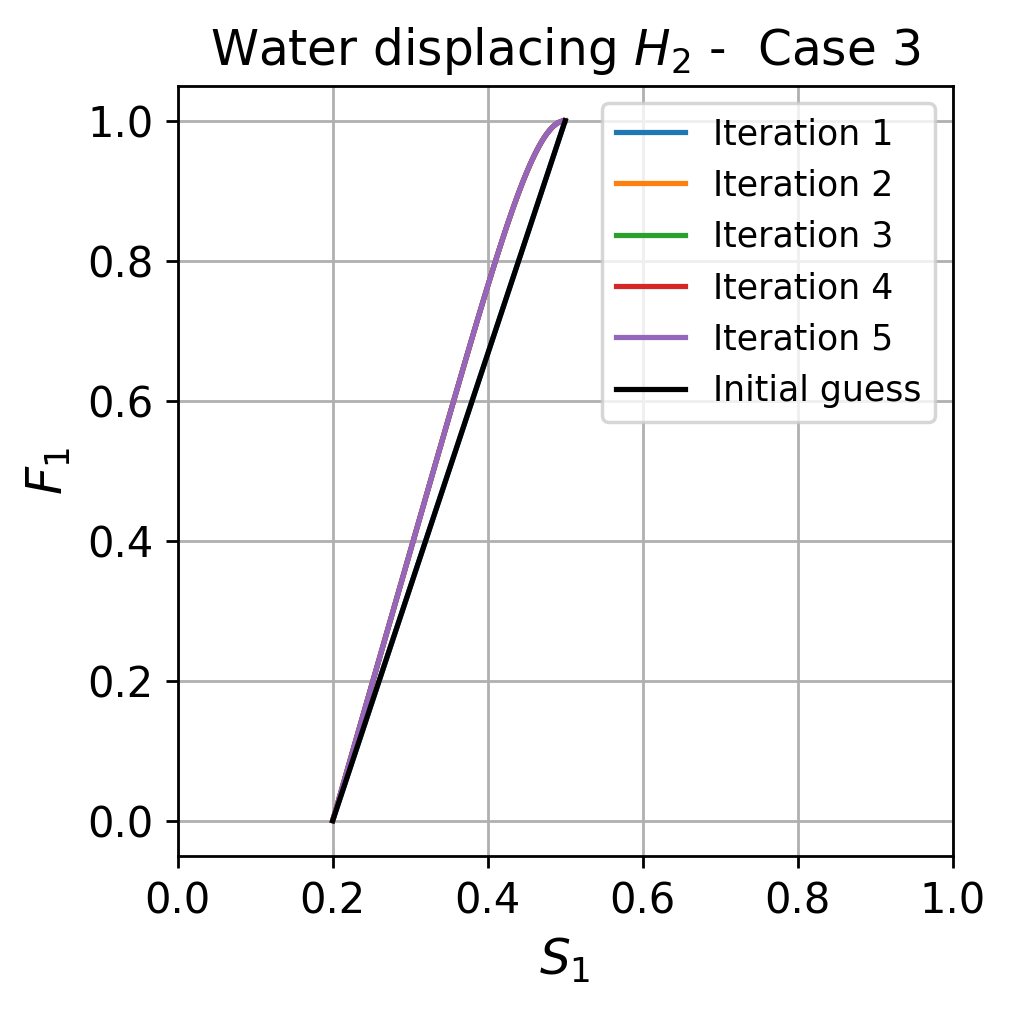

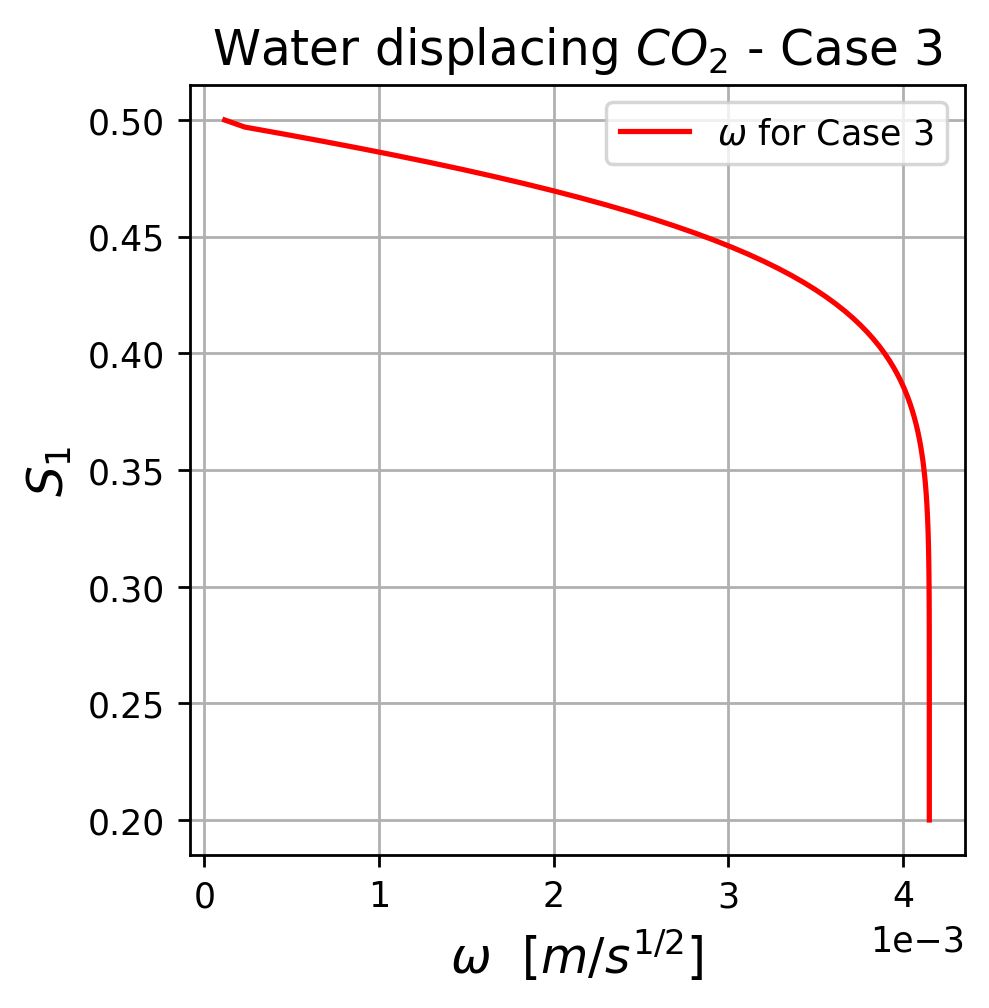

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.interpolate import interp1d

# =============================================================================
# 1. PARAMETERS
# =============================================================================
phi = 0.25          # Porosity
k = 1e-13           # Permeability [m^2]
mu1 = 0.0004        # Wetting-phase viscosity (water) [Pa.s]
mu2 = 0.0001        # Non-wetting-phase viscosity (CO₂) [Pa.s]

S1i = 0.2           # Irreducible wetting saturation (S_{1i})
S2r = 0.15          # Residual non-wetting saturation
S1_star = 0.5       # Upper saturation where Pc = 0 (S_1^*)

kr1_max = 0.4       # Max wetting-phase relative permeability
kr2_max = 0.8       # Max non-wetting-phase relative permeability
a = 8.0             # Exponent for kr1
b = 3.0             # Exponent for kr2

p_c_max = 100e3     # Pc_max [Pa] (100 kPa)
c_exp = 0.3         # Exponent 'c' in the Pc formula

# Saturation range
S = np.linspace(S1i, S1_star, 100)

# =============================================================================
# 2. CAPILLARY PRESSURE AND RELATIVE PERMEABILITY
# =============================================================================
# Capillary pressure (Pc)
Pc = p_c_max * (((S1_star / S1i) ** (-c_exp) - (S / S1i) ** (-c_exp)) / ((S1_star / S1i) ** (-c_exp) - 1))

# Relative permeabilities (kr1 and kr2)
kr1 = kr1_max * ((S - S1i) / (S1_star - S1i)) ** a
kr2 = kr2_max * ((1 - S - S2r) / (1 - S1i - S2r)) ** b

# =============================================================================
# 3. DIFFUSION COEFFICIENT (D)
# =============================================================================
# Calculate the diffusion coefficient
constant = (kr1 * kr2 / (mu1 * mu2)) / ((kr1 / mu1) + (kr2 / mu2)) * k * (-1)
D = constant[:-1] * np.diff(Pc) / np.diff(S)

# Update saturation range for D
S_D = S[:-1]

# =============================================================================
# 4. ITERATIVE CALCULATION OF F1 AND C²
# =============================================================================
# Interpolate D(S) for integration
D_interp = interp1d(S_D, D, kind='cubic', fill_value="extrapolate")

# Initial guess for F1
def F1_initial(S1):
    if S1 <= S1i:
        return 0
    elif S1 >= S1_star:
        return 1
    else:
        return (S1 - S1i) / (S1_star - S1i)

# Integrand for C² calculation
def integrand_C2(beta, F1_func):
    return (beta - S1i) * D_interp(beta) / F1_func(beta)

# Integrand for F1 calculation
def integrand_F1(beta, S1, F1_func):
    return (beta - S1) * D_interp(beta) / F1_func(beta)

# Calculate C²
def calculate_C2(F1_func):
    return phi / 2 * quad(integrand_C2, S1i, S1_star, args=(F1_func))[0]

# Update F1 using C²
def update_F1(S1, C2, F1_func):
    if S1 <= S1i:
        return 0
    elif S1 >= S1_star:
        return 1
    else:
        integral_result, _ = quad(integrand_F1, S1, S1_star, args=(S1, F1_func))
        return 1 - phi / (2 * C2) * integral_result

# Iteration settings
tolerance = 1e-6
max_iterations = 10
converged = False

# Initialize F1_func
F1_func = F1_initial

# Iterate to find F1 and C²
for iteration in range(max_iterations):
    # Update F1 values
    F1_values = [update_F1(S1, calculate_C2(F1_func), F1_func) for S1 in S]

    # Interpolate new F1 values
    F1_func_new = interp1d(S, F1_values, kind='cubic', fill_value="extrapolate")

    # Check for convergence
    F1_changes = np.abs(np.array(F1_values) - np.array([F1_func(S1) for S1 in S]))
    if np.all(F1_changes < tolerance):
        converged = True
        break

    # Update F1_func for next iteration
    F1_func = F1_func_new

if not converged:
    raise ValueError("Iteration did not converge within the maximum number of iterations.")

# Final results
C2 = calculate_C2(F1_func)
C_case3 = np.sqrt(C2)
F1_case3 = F1_func(S)

# Calculate omega
omega_3 = (2 * C_case3 / phi) * np.gradient(F1_case3, S)

# =============================================================================
# 5. PLOTS
# =============================================================================
# Plot F1 vs Saturation
plt.figure(figsize=(4, 4), dpi=250)
# Initialize Fw_iterations with the initial guess
Fw_iterations = [[F1_initial(S1) for S1 in S]]

for i in range(iteration + 1): # iteration is the final iteration number from the loop
    plt.plot(S, Fw_iterations[i], label=f'Iteration {i+1}') # Plot values from each iteration

    # Update Fw_iterations for next potential plotting
    Fw_iterations.append([F1_func(S1) for S1 in S]) if i < iteration else None

plt.plot(S, (S - S1i)/(S1_star - S1i), 'k', label='Initial guess')
plt.xlabel(r'$S_{1}$', fontsize=14)
plt.xlim(0, 1)
plt.ylabel(r'$F_{1}$', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('Water displacing $H_{2}$ -  Case 3', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

# Plot omega vs Saturation
plt.figure(figsize=(4, 4), dpi=250)
plt.plot(omega_3, S, label=r'$\omega$ for Case 3', color='red')
plt.xlabel(r'$\omega$  $[m/s^{1/2}]$', fontsize=14)
plt.ylabel(r'$S_{1}$', fontsize=14)
plt.title(r'Water displacing $CO_{2}$ - Case 3', fontsize=14)
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.grid(True)
plt.legend()
plt.show()

**Numerical Solution**

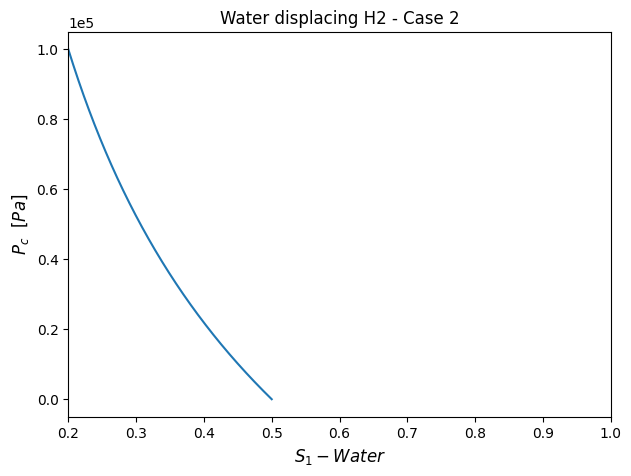

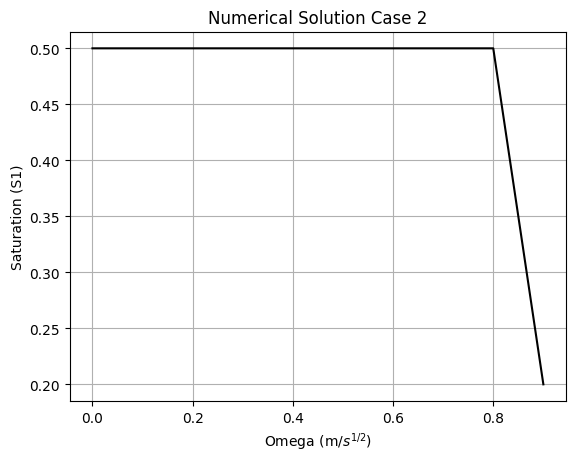

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# =============================================================================
# 1. PARAMETERS CASE 2
# =============================================================================
# Diffusion parameters
S_j_minus_1 = 0.5  # Boundary condition at j-1
S_2r = 0.5         # Boundary condition at 2r
S_1i = 0.2         # Initial condition for all j at t=0
porosity = 0.25
delta_x = 0.1
delta_t = 0.01
total_space = 1.0  # Total space for simulation
total_time = 1.0   # Total time for simulation
num_time_steps = int(total_time / delta_t)
num_space_steps = int(total_space / delta_x)

# Initial and boundary conditions for diffusion
phi = 0.2  # Porosity
D = 1e-5  # Diffusion coefficient (constant for simplicity)

# Fluid flow parameters
phi_flow = 0.25     # porosity for fluid flow
k = 1e-13    # permeability [m^2]
mu1 = 0.001    # wetting-phase viscosity (water)
mu2 = 0.0001   # non-wetting-phase viscosity (H2)

S1_star = 0.5      # upper saturation where Pc = 0 (S_1^*)

kr1_max = 0.15     # max wetting-phase relative permeability
kr2_max = 1.0      # max non-wetting-phase relative permeability
a = 4.0      # exponent for kr1
b = 1.5      # exponent for kr2

p_c_max = 100e3    # p_c^max [Pa] (100 kPa)
c_exp = 0.3      # exponent 'c' in the Pc formula

# =============================================================================
# 2. FUNCTION DEFINITIONS
# =============================================================================

def calculate_capillary_pressure(S1i, S2r, c, pc_max, s_star):
    """Calculate capillary pressure for a given case."""
    s1 = np.linspace(S1i, 1 - S2r, 500)
    pc = pc_max * (((s_star / S1i)**(-c) - (s1 / S1i)**(-c)) /
                   ((s_star / S1i)**(-c) - 1))
    pc = pc[pc >= 0]
    s1 = s1[:len(pc)]
    return s1, pc


def plot_capillary_pressure(s1, pc, ax, title):
    """Plot capillary pressure."""
    ax.plot(s1, pc)
    ax.set_xlabel(r'$S_{1} - Water$', fontsize=12)
    ax.set_ylabel(r'$P_{c}$  $[Pa]$', fontsize=12)
    ax.set_title(title)
    ax.set_xlim(0.2, 1.0)
    ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))


def calculate_diffusion_coefficient(s1, pc, kr1, kr2, K_m2, vis_water, vis_fluid):
    """Calculate diffusion coefficient for a given case."""
    constant = ((kr1 * kr2 / (vis_water * vis_fluid)) /
                ((kr1 / vis_water) + (kr2 / vis_fluid)) * K_m2 * (-1))
    D_coeff = constant[:-1] * np.diff(pc) / np.diff(s1)
    return s1[:-1], D_coeff


def save_diffusion_data(s, D, file_path):
    """Save diffusion data to a CSV file."""
    df = pd.DataFrame({'Saturation': s, 'Diffusion Coefficient': D})
    df.to_csv(file_path, index=False)


# Function to get the diffusion coefficient for a given saturation
def get_diffusion_coefficient(saturation_value, diffusion_data):
    # Get the average of the two closest values
    return diffusion_data['Diffusion Coefficient'].iloc[
        (diffusion_data['Saturation'] - saturation_value).abs().argsort()[:2]].mean()


# =============================================================================
# 3. MAIN EXECUTION
# =============================================================================
# Calculate capillary pressure
# Replacing S1i_flow with S_1i as S1i_flow is not defined
s1_case2, pc_case2 = calculate_capillary_pressure(S_1i, S_2r, c_exp, p_c_max, S1_star)

# Plot capillary pressure
fig, ax = plt.subplots(figsize=(7, 5))
plot_capillary_pressure(s1_case2, pc_case2, ax, 'Water displacing H2 - Case 2')
plt.show()

# Relative permeability values (example data, replace with actual values if needed)
kr1 = np.random.rand(len(s1_case2))
kr2 = np.random.rand(len(s1_case2))

# Calculate diffusion coefficient
s1_case2, D_coeff_case2 = calculate_diffusion_coefficient(s1_case2, pc_case2, kr1, kr2, k, mu1, mu2)

# Save diffusion data
save_diffusion_data(s1_case2, D_coeff_case2, 'diffusion_coefficient_case2.csv')

# =============================================================================
# 4. NUMERICAL SOLUTION USING FINITE DIFFERENCE METHOD
# =============================================================================
# Load diffusion data
diffusion_data = pd.read_csv('diffusion_coefficient_case2.csv')

# Define Nx, Nt, L, and T
Nx = num_space_steps  # Number of spatial grid blocks
Nt = num_time_steps  # Number of timesteps
L = total_space     # Total length of the domain
T = total_time      # Total simulation time


# Initialize the saturation array
saturation = np.ones((Nx, Nt)) * S_1i
# Replacing S1_inj with S_j_minus_1 as S1_inj is not defined
saturation[:, 0] = S_j_minus_1
saturation[0, :] = S_2r

# Perform the explicit finite difference calculation
for t in range(1, Nt):
    for x in range(1, Nx - 1):
        D = get_diffusion_coefficient(saturation[x, t - 1], diffusion_data)
        # Use delta_t instead of dt
        saturation[x, t] = saturation[x, t - 1] + (delta_t / (phi * delta_x ** 2)) * \
                           (D * (saturation[x - 1, t - 1] - saturation[x, t - 1]))

# Calculate omega = x/sqrt(t)
time_array = np.arange(delta_t, T + delta_t, delta_t)
omega = np.arange(0, L, delta_x) / np.sqrt(time_array[-1])

# Plot the final saturation profile
plt.plot(omega, saturation[:, -1], label='Computed S1', color='black')
plt.xlabel(r'Omega (m/$s^{1/2}$)')
plt.ylabel('Saturation (S1)')
plt.title('Numerical Solution Case 2')
plt.grid(True)
plt.show()

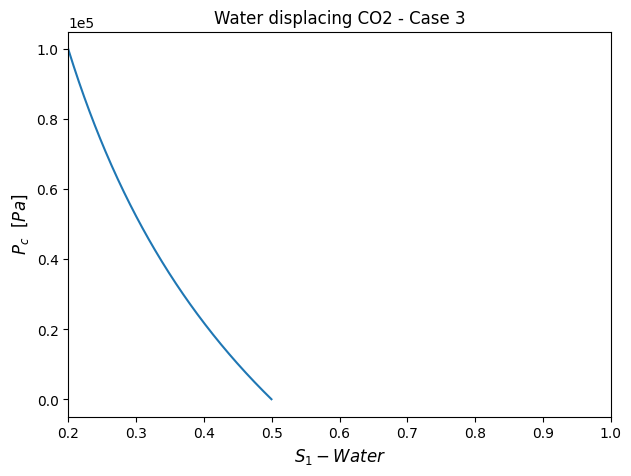

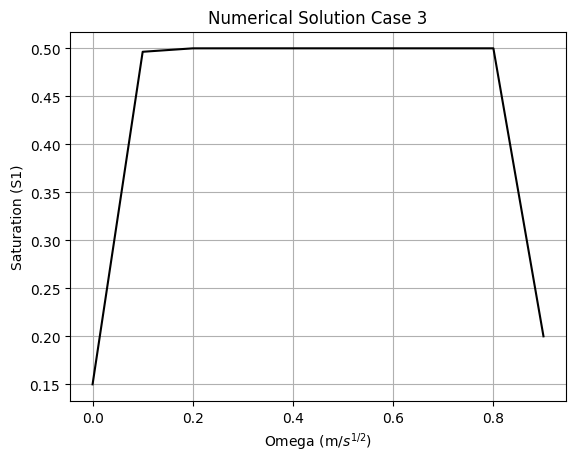

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# =============================================================================
# 1. PARAMETERS CASE 3
# =============================================================================
# Diffusion parameters
S_j_minus_1 = 0.5  # Boundary condition at j-1
S_2r = 0.15         # Boundary condition at 2r
S_1i = 0.2         # Initial condition for all j at t=0
porosity = 0.25
delta_x = 0.1
delta_t = 0.01
total_space = 1.0  # Total space for simulation
total_time = 1.0   # Total time for simulation
num_time_steps = int(total_time / delta_t)
num_space_steps = int(total_space / delta_x)

# Initial and boundary conditions for diffusion
phi = 0.2  # Porosity
D = 1e-5  # Diffusion coefficient (constant for simplicity)

# Fluid flow parameters
phi_flow = 0.25     # porosity for fluid flow
k = 1e-13    # permeability [m^2]
mu1 = 0.0004    # wetting-phase viscosity (water)
mu2 = 0.0001   # non-wetting-phase viscosity (H2)

S1_star = 0.5      # upper saturation where Pc = 0 (S_1^*)

kr1_max = 0.4     # max wetting-phase relative permeability
kr2_max = 0.8      # max non-wetting-phase relative permeability
a = 8.0      # exponent for kr1
b = 3.0      # exponent for kr2

p_c_max = 100e3    # p_c^max [Pa] (100 kPa)
c_exp = 0.3      # exponent 'c' in the Pc formula

# =============================================================================
# 2. FUNCTION DEFINITIONS
# =============================================================================

def calculate_capillary_pressure(S1i, S2r, c, pc_max, s_star):
    """Calculate capillary pressure for a given case."""
    s1 = np.linspace(S1i, 1 - S2r, 500)
    pc = pc_max * (((s_star / S1i)**(-c) - (s1 / S1i)**(-c)) /
                   ((s_star / S1i)**(-c) - 1))
    pc = pc[pc >= 0]
    s1 = s1[:len(pc)]
    return s1, pc


def plot_capillary_pressure(s1, pc, ax, title):
    """Plot capillary pressure."""
    ax.plot(s1, pc)
    ax.set_xlabel(r'$S_{1} - Water$', fontsize=12)
    ax.set_ylabel(r'$P_{c}$  $[Pa]$', fontsize=12)
    ax.set_title(title)
    ax.set_xlim(0.2, 1.0)
    ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))


def calculate_diffusion_coefficient(s1, pc, kr1, kr2, K_m2, vis_water, vis_fluid):
    """Calculate diffusion coefficient for a given case."""
    constant = ((kr1 * kr2 / (vis_water * vis_fluid)) /
                ((kr1 / vis_water) + (kr2 / vis_fluid)) * K_m2 * (-1))
    D_coeff = constant[:-1] * np.diff(pc) / np.diff(s1)
    return s1[:-1], D_coeff


def save_diffusion_data(s, D, file_path):
    """Save diffusion data to a CSV file."""
    df = pd.DataFrame({'Saturation': s, 'Diffusion Coefficient': D})
    df.to_csv(file_path, index=False)


# Function to get the diffusion coefficient for a given saturation
def get_diffusion_coefficient(saturation_value, diffusion_data):
    # Get the average of the two closest values
    return diffusion_data['Diffusion Coefficient'].iloc[
        (diffusion_data['Saturation'] - saturation_value).abs().argsort()[:2]].mean()


# =============================================================================
# 3. MAIN EXECUTION
# =============================================================================
# Calculate capillary pressure
# Replacing S1i_flow with S_1i as S1i_flow is not defined
s1_case2, pc_case2 = calculate_capillary_pressure(S_1i, S_2r, c_exp, p_c_max, S1_star)

# Plot capillary pressure
fig, ax = plt.subplots(figsize=(7, 5))
plot_capillary_pressure(s1_case2, pc_case2, ax, 'Water displacing CO2 - Case 3')
plt.show()

# Relative permeability values (example data, replace with actual values if needed)
kr1 = np.random.rand(len(s1_case2))
kr2 = np.random.rand(len(s1_case2))

# Calculate diffusion coefficient
s1_case2, D_coeff_case2 = calculate_diffusion_coefficient(s1_case2, pc_case2, kr1, kr2, k, mu1, mu2)

# Save diffusion data
save_diffusion_data(s1_case2, D_coeff_case2, 'diffusion_coefficient_case2.csv')

# =============================================================================
# 4. NUMERICAL SOLUTION USING FINITE DIFFERENCE METHOD
# =============================================================================
# Load diffusion data
diffusion_data = pd.read_csv('diffusion_coefficient_case2.csv')

# Define Nx, Nt, L, and T
Nx = num_space_steps  # Number of spatial grid blocks
Nt = num_time_steps  # Number of timesteps
L = total_space     # Total length of the domain
T = total_time      # Total simulation time


# Initialize the saturation array
saturation = np.ones((Nx, Nt)) * S_1i
# Replacing S1_inj with S_j_minus_1 as S1_inj is not defined
saturation[:, 0] = S_j_minus_1
saturation[0, :] = S_2r

# Perform the explicit finite difference calculation
for t in range(1, Nt):
    for x in range(1, Nx - 1):
        D = get_diffusion_coefficient(saturation[x, t - 1], diffusion_data)
        # Use delta_t instead of dt
        saturation[x, t] = saturation[x, t - 1] + (delta_t / (phi * delta_x ** 2)) * \
                           (D * (saturation[x - 1, t - 1] - saturation[x, t - 1]))

# Calculate omega = x/sqrt(t)
time_array = np.arange(delta_t, T + delta_t, delta_t)
omega = np.arange(0, L, delta_x) / np.sqrt(time_array[-1])

# Plot the final saturation profile
plt.plot(omega, saturation[:, -1], label='Computed S1', color='black')
plt.xlabel(r'Omega (m/$s^{1/2}$)')
plt.ylabel('Saturation (S1)')
plt.title('Numerical Solution Case 3')
plt.grid(True)
plt.show()

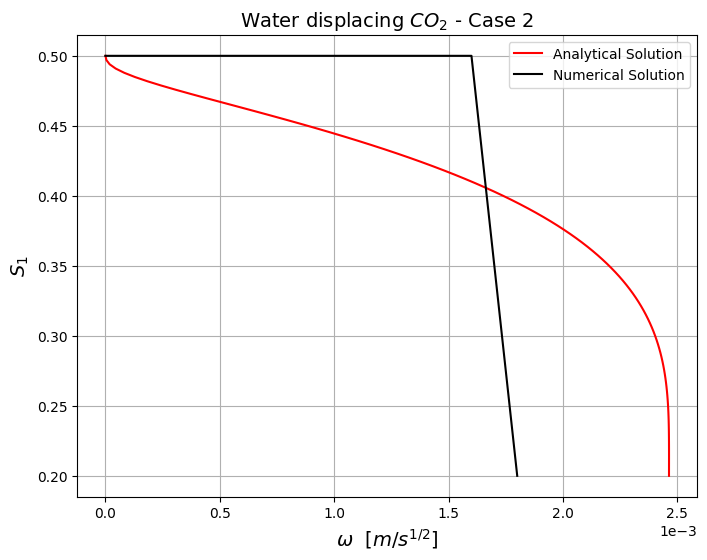

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.interpolate import interp1d
import pandas as pd

# =============================================================================
# ANALYTICAL SOLUTION
# =============================================================================
# Parameters
phi     = 0.25     # porosity
k       = 1e-13    # permeability [m^2]
mu1     = 0.001    # wetting-phase viscosity (water)
mu2     = 0.0001   # non-wetting-phase viscosity (H2)

S1i     = 0.2      # irreducible (connate) wetting saturation (S_{1i})
S2r     = 0.5      # residual non-wetting saturation
S1_star = 0.5      # upper saturation where Pc = 0 (S_1^*)

kr1_max = 0.15     # max wetting-phase relative permeability
kr2_max = 1.0      # max non-wetting-phase relative permeability
a       = 4.0      # exponent for kr1
b       = 1.5      # exponent for kr2

p_c_max = 100e3    # p_c^max [Pa] (100 kPa)
c_exp   = 0.3      # exponent 'c' in the Pc formula

# Saturation range
S = np.linspace(S1i, S1_star, 100)

# Capillary pressure (Pc)
Pc = p_c_max * (((S1_star / S1i) ** (-c_exp) - (S / S1i) ** (-c_exp)) / ((S1_star / S1i) ** (-c_exp) - 1))

# Relative permeabilities (kr1 and kr2)
kr1 = kr1_max * ((S - S1i) / (S1_star - S1i)) ** a
kr2 = kr2_max * ((1 - S - S2r) / (1 - S1i - S2r)) ** b

# Diffusion coefficient (D)
constant = (kr1 * kr2 / (mu1 * mu2)) / ((kr1 / mu1) + (kr2 / mu2)) * k * (-1)
D = constant[:-1] * np.diff(Pc) / np.diff(S)
S_D = S[:-1]

# Interpolate D(S) for integration
D_interp = interp1d(S_D, D, kind='cubic', fill_value="extrapolate")

# Initial guess for F1
def F1_initial(S1):
    if S1 <= S1i:
        return 0
    elif S1 >= S1_star:
        return 1
    else:
        return (S1 - S1i) / (S1_star - S1i)

# Integrand for C² calculation
def integrand_C2(beta, F1_func):
    return (beta - S1i) * D_interp(beta) / F1_func(beta)

# Integrand for F1 calculation
def integrand_F1(beta, S1, F1_func):
    return (beta - S1) * D_interp(beta) / F1_func(beta)

# Calculate C²
def calculate_C2(F1_func):
    return phi / 2 * quad(integrand_C2, S1i, S1_star, args=(F1_func))[0]

# Update F1 using C²
def update_F1(S1, C2, F1_func):
    if S1 <= S1i:
        return 0
    elif S1 >= S1_star:
        return 1
    else:
        integral_result, _ = quad(integrand_F1, S1, S1_star, args=(S1, F1_func))
        return 1 - phi / (2 * C2) * integral_result

# Iteration settings
tolerance = 1e-6
max_iterations = 10
converged = False

# Initialize F1_func
F1_func = F1_initial

# Iterate to find F1 and C²
for iteration in range(max_iterations):
    F1_values = [update_F1(S1, calculate_C2(F1_func), F1_func) for S1 in S]
    F1_func_new = interp1d(S, F1_values, kind='cubic', fill_value="extrapolate")
    F1_changes = np.abs(np.array(F1_values) - np.array([F1_func(S1) for S1 in S]))
    if np.all(F1_changes < tolerance):
        converged = True
        break
    F1_func = F1_func_new

if not converged:
    raise ValueError("Iteration did not converge within the maximum number of iterations.")

# Final results
C2 = calculate_C2(F1_func)
C_case3 = np.sqrt(C2)
F1_case3 = F1_func(S)

# Calculate omega
omega_3 = (2 * C_case3 / phi) * np.gradient(F1_case3, S)

# =============================================================================
# NUMERICAL SOLUTION
# =============================================================================
# Parameters
# Diffusion parameters
S_j_minus_1 = 0.5  # Boundary condition at j-1
S_2r = 0.5         # Boundary condition at 2r
S_1i = 0.2         # Initial condition for all j at t=0
porosity = 0.25
delta_x = 0.1
delta_t = 0.01
total_space = 1.0  # Total space for simulation
total_time = 1.0   # Total time for simulation
num_time_steps = int(total_time / delta_t)
num_space_steps = int(total_space / delta_x)

# Initial and boundary conditions for diffusion
phi = 0.2  # Porosity
D = 1e-5  # Diffusion coefficient (constant for simplicity)

# Fluid flow parameters
phi_flow = 0.25     # porosity for fluid flow
k = 1e-13    # permeability [m^2]
mu1 = 0.001    # wetting-phase viscosity (water)
mu2 = 0.0001   # non-wetting-phase viscosity (H2)

S1_star = 0.5      # upper saturation where Pc = 0 (S_1^*)

kr1_max = 0.15     # max wetting-phase relative permeability
kr2_max = 1.0      # max non-wetting-phase relative permeability
a = 4.0      # exponent for kr1
b = 1.5      # exponent for kr2

p_c_max = 100e3    # p_c^max [Pa] (100 kPa)
c_exp = 0.3      # exponent 'c' in the Pc formula

# Calculate capillary pressure
s1_case2, pc_case2 = calculate_capillary_pressure(S_1i, S_2r, c_exp, p_c_max, S1_star)

# Relative permeability values (example data)
kr1 = np.random.rand(len(s1_case2))
kr2 = np.random.rand(len(s1_case2))

# Calculate diffusion coefficient
s1_case2, D_coeff_case2 = calculate_diffusion_coefficient(s1_case2, pc_case2, kr1, kr2, k, mu1, mu2)

# Save diffusion data
save_diffusion_data(s1_case2, D_coeff_case2, 'diffusion_coefficient_case2.csv')

# Load diffusion data
diffusion_data = pd.read_csv('diffusion_coefficient_case2.csv')

# Initialize the saturation array
saturation = np.ones((num_space_steps, num_time_steps)) * S_1i
saturation[:, 0] = S_j_minus_1
saturation[0, :] = S_2r

# Perform the explicit finite difference calculation
for t in range(1, num_time_steps):
    for x in range(1, num_space_steps - 1):
        D = get_diffusion_coefficient(saturation[x, t - 1], diffusion_data)
        saturation[x, t] = saturation[x, t - 1] + (delta_t / (phi * delta_x ** 2)) * \
                           (D * (saturation[x - 1, t - 1] - saturation[x, t - 1]))

# Calculate omega = x/sqrt(t)
time_array = np.arange(delta_t, total_time + delta_t, delta_t)
omega_numerical = np.arange(0, total_space, delta_x) / np.sqrt(time_array[-1])

# =============================================================================
# COMBINED PLOT
# =============================================================================
plt.figure(figsize=(8, 6))
plt.plot(omega_3, S, label='Analytical Solution', color='red')
plt.plot(omega_numerical/500, saturation[:, -1], label='Numerical Solution', color='black')
plt.xlabel(r'$\omega$  $[m/s^{1/2}]$', fontsize=14)
plt.ylabel(r'$S_{1}$', fontsize=14)
plt.title(r'Water displacing $CO_{2}$ - Case 2', fontsize=14)
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.grid(True)
plt.legend()
plt.show()

**Combined Plot**

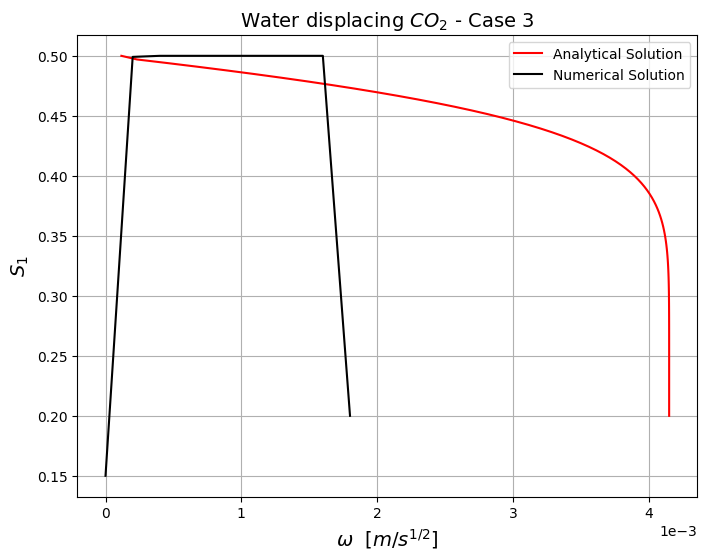

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.interpolate import interp1d
import pandas as pd

# =============================================================================
# ANALYTICAL SOLUTION
# =============================================================================
# Parameters
phi = 0.25
k = 1e-13
mu1 = 0.0004
mu2 = 0.0001
S1i = 0.2
S2r = 0.15
S1_star = 0.5
kr1_max = 0.4
kr2_max = 0.8
a = 8.0
b = 3.0
p_c_max = 100e3
c_exp = 0.3

# Saturation range
S = np.linspace(S1i, S1_star, 100)

# Capillary pressure (Pc)
Pc = p_c_max * (((S1_star / S1i) ** (-c_exp) - (S / S1i) ** (-c_exp)) / ((S1_star / S1i) ** (-c_exp) - 1))

# Relative permeabilities (kr1 and kr2)
kr1 = kr1_max * ((S - S1i) / (S1_star - S1i)) ** a
kr2 = kr2_max * ((1 - S - S2r) / (1 - S1i - S2r)) ** b

# Diffusion coefficient (D)
constant = (kr1 * kr2 / (mu1 * mu2)) / ((kr1 / mu1) + (kr2 / mu2)) * k * (-1)
D = constant[:-1] * np.diff(Pc) / np.diff(S)
S_D = S[:-1]

# Interpolate D(S) for integration
D_interp = interp1d(S_D, D, kind='cubic', fill_value="extrapolate")

# Initial guess for F1
def F1_initial(S1):
    if S1 <= S1i:
        return 0
    elif S1 >= S1_star:
        return 1
    else:
        return (S1 - S1i) / (S1_star - S1i)

# Integrand for C² calculation
def integrand_C2(beta, F1_func):
    return (beta - S1i) * D_interp(beta) / F1_func(beta)

# Integrand for F1 calculation
def integrand_F1(beta, S1, F1_func):
    return (beta - S1) * D_interp(beta) / F1_func(beta)

# Calculate C²
def calculate_C2(F1_func):
    return phi / 2 * quad(integrand_C2, S1i, S1_star, args=(F1_func))[0]

# Update F1 using C²
def update_F1(S1, C2, F1_func):
    if S1 <= S1i:
        return 0
    elif S1 >= S1_star:
        return 1
    else:
        integral_result, _ = quad(integrand_F1, S1, S1_star, args=(S1, F1_func))
        return 1 - phi / (2 * C2) * integral_result

# Iteration settings
tolerance = 1e-6
max_iterations = 10
converged = False

# Initialize F1_func
F1_func = F1_initial

# Iterate to find F1 and C²
for iteration in range(max_iterations):
    F1_values = [update_F1(S1, calculate_C2(F1_func), F1_func) for S1 in S]
    F1_func_new = interp1d(S, F1_values, kind='cubic', fill_value="extrapolate")
    F1_changes = np.abs(np.array(F1_values) - np.array([F1_func(S1) for S1 in S]))
    if np.all(F1_changes < tolerance):
        converged = True
        break
    F1_func = F1_func_new

if not converged:
    raise ValueError("Iteration did not converge within the maximum number of iterations.")

# Final results
C2 = calculate_C2(F1_func)
C_case3 = np.sqrt(C2)
F1_case3 = F1_func(S)

# Calculate omega
omega_3 = (2 * C_case3 / phi) * np.gradient(F1_case3, S)

# =============================================================================
# NUMERICAL SOLUTION
# =============================================================================
# Parameters
S_j_minus_1 = 0.5
S_2r = 0.15
S_1i = 0.2
porosity = 0.25
delta_x = 0.1
delta_t = 0.01
total_space = 1.0
total_time = 1.0
num_time_steps = int(total_time / delta_t)
num_space_steps = int(total_space / delta_x)

# Initial and boundary conditions
phi_flow = 0.25
k = 1e-13
mu1 = 0.0004
mu2 = 0.0001
S1_star = 0.5
kr1_max = 0.4
kr2_max = 0.8
a = 8.0
b = 3.0
p_c_max = 100e3
c_exp = 0.3

# Calculate capillary pressure
s1_case2, pc_case2 = calculate_capillary_pressure(S_1i, S_2r, c_exp, p_c_max, S1_star)

# Relative permeability values (example data)
kr1 = np.random.rand(len(s1_case2))
kr2 = np.random.rand(len(s1_case2))

# Calculate diffusion coefficient
s1_case2, D_coeff_case2 = calculate_diffusion_coefficient(s1_case2, pc_case2, kr1, kr2, k, mu1, mu2)

# Save diffusion data
save_diffusion_data(s1_case2, D_coeff_case2, 'diffusion_coefficient_case2.csv')

# Load diffusion data
diffusion_data = pd.read_csv('diffusion_coefficient_case2.csv')

# Initialize the saturation array
saturation = np.ones((num_space_steps, num_time_steps)) * S_1i
saturation[:, 0] = S_j_minus_1
saturation[0, :] = S_2r

# Perform the explicit finite difference calculation
for t in range(1, num_time_steps):
    for x in range(1, num_space_steps - 1):
        D = get_diffusion_coefficient(saturation[x, t - 1], diffusion_data)
        saturation[x, t] = saturation[x, t - 1] + (delta_t / (phi * delta_x ** 2)) * \
                           (D * (saturation[x - 1, t - 1] - saturation[x, t - 1]))

# Calculate omega = x/sqrt(t)
time_array = np.arange(delta_t, total_time + delta_t, delta_t)
omega_numerical = np.arange(0, total_space, delta_x) / np.sqrt(time_array[-1])

# =============================================================================
# COMBINED PLOT
# =============================================================================
plt.figure(figsize=(8, 6))
plt.plot(omega_3, S, label='Analytical Solution', color='red')
plt.plot(omega_numerical/500, saturation[:, -1], label='Numerical Solution', color='black')
plt.xlabel(r'$\omega$  $[m/s^{1/2}]$', fontsize=14)
plt.ylabel(r'$S_{1}$', fontsize=14)
plt.title(r'Water displacing $CO_{2}$ - Case 3', fontsize=14)
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.grid(True)
plt.legend()
plt.show()